In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from environment import TrafficModel, Car
from util.network import create_braess_network, create_double_braess_network, create_cars

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import trange

## Find optimal capacity for unrestricted vs. restricted

100%|██████████| 28/28 [00:21<00:00,  1.31it/s]


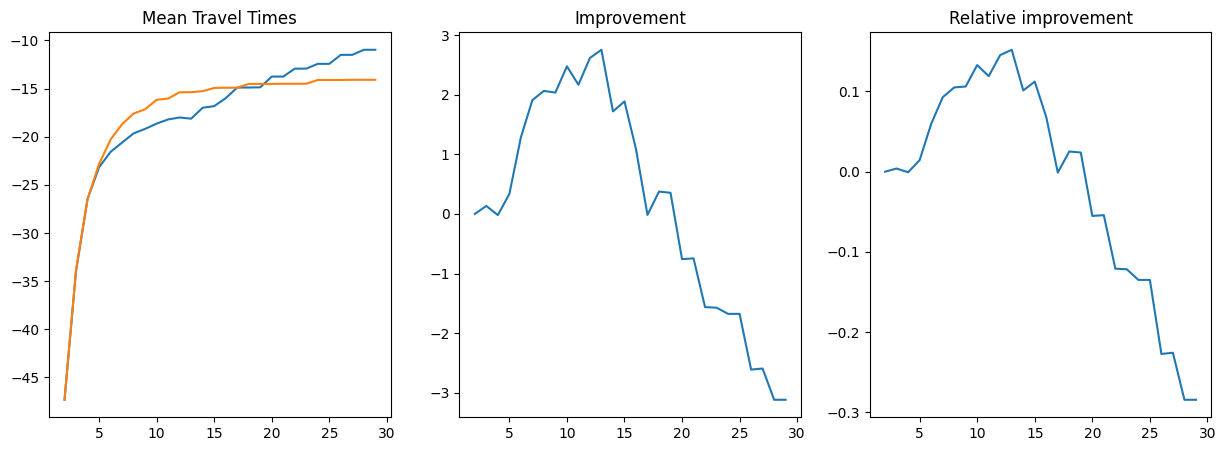

Best improvement found with capacity: 13


In [7]:
number_of_steps = 1000
car_counts = {(0, 3): 30}

mean_travel_times_allowed = []
mean_travel_times_prohibited = []
for capacity in trange(2, 30):
    for allowed_edge in [True, False]:
        network = create_braess_network(capacity=capacity)
        model = TrafficModel(network, create_cars(network, car_counts=car_counts))
        model.set_edge_restriction((1, 2), allowed=allowed_edge)
        step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

        if allowed_edge:
            mean_travel_times_allowed.append((-car_stats["travel_time"]).mean())
        else:
            mean_travel_times_prohibited.append((-car_stats["travel_time"]).mean())

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(range(2,30), pd.DataFrame({'allowed': mean_travel_times_allowed, 'prohibited': mean_travel_times_prohibited}))
ax1.set_title('Mean Travel Times')

improvement = np.array(mean_travel_times_prohibited) - np.array(mean_travel_times_allowed)
ax2.plot(range(2,30), improvement)
ax2.set_title('Improvement')

relative_improvement = improvement / abs(np.array(mean_travel_times_allowed))
ax3.plot(range(2,30), relative_improvement)
ax3.set_title('Relative improvement')

plt.show()

print(f'Best improvement found with capacity: {np.argmax(improvement) + 2}')

## Test scenarios individually

In [10]:
def plot_results(car_stats, *, title):
    stats = car_stats.set_index('step')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    pd.DataFrame({route: stats['route'] == route for route in stats['route'].unique()}).expanding().mean().plot(ax=ax1)
    ax1.legend(stats['route'].unique())
    ax1.set_title('Fraction of cars per route')

    pd.DataFrame({'Travel time': stats['travel_time'], 'Total cost': stats['total_cost']}).expanding().mean().plot(ax=ax2)
    ax2.set_title('Social welfare')

    fig.suptitle(title)

### Unrestricted

In [11]:
network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

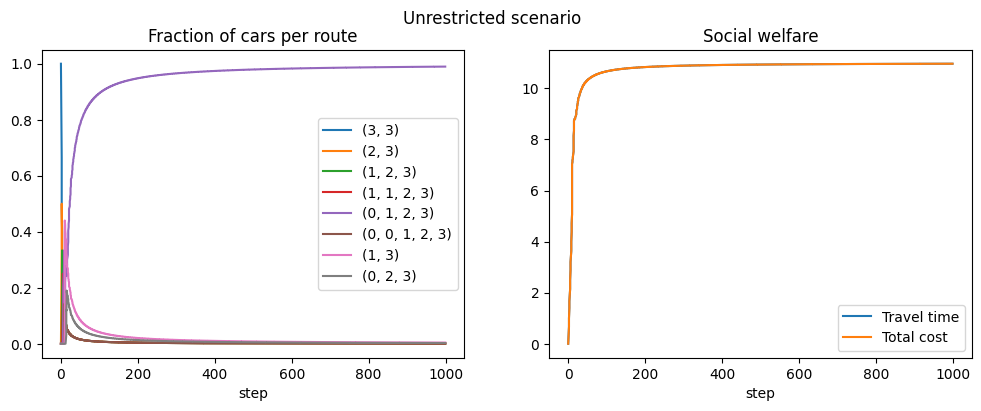

In [12]:
plot_results(car_stats, title='Unrestricted scenario')

### Restricted

In [105]:
network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
model.set_edge_restriction((1, 2), False)
step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

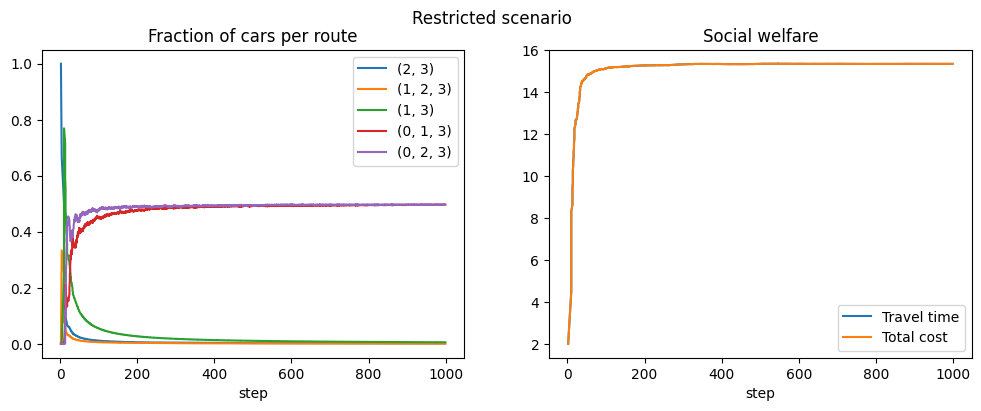

In [106]:
plot_results(car_stats, title='Restricted scenario')

### Tolling

Mean travel time with tolling: -15.463762130910593
Mean total cost with tolling: -19.694953168827674


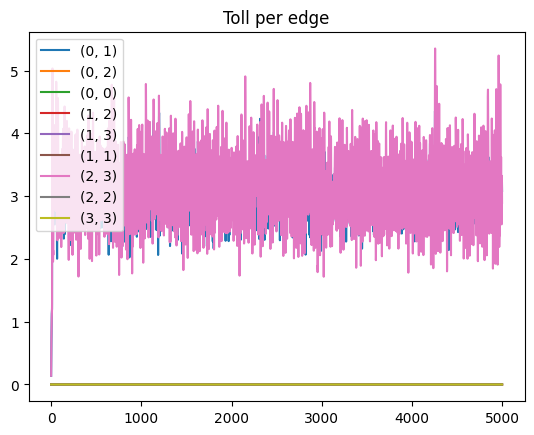

In [107]:
from util.analysis import plot_toll_per_edge, plot_cars_per_edge

network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts), tolls=True, beta=1, R=0.1)
step_stats, car_stats = model.run_sequentially(5000, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats["total_cost"]).mean()}')

plot_toll_per_edge(step_stats)

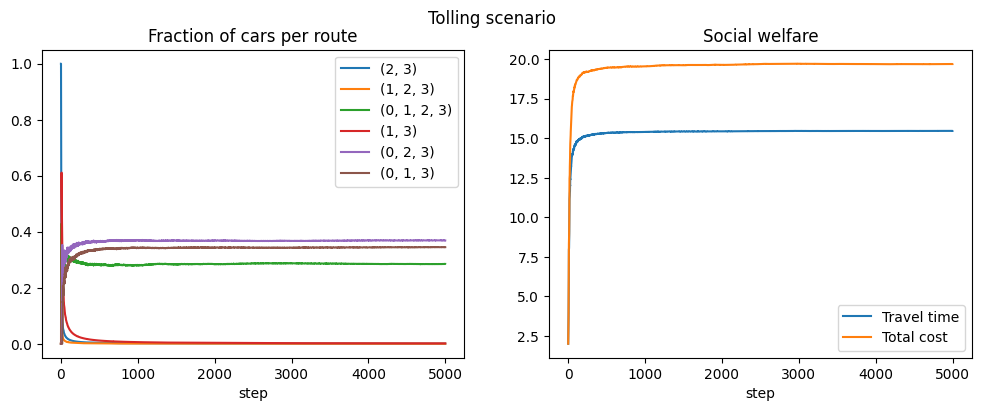

In [108]:
plot_results(car_stats, title='Tolling scenario')

## Compare unrestricted vs. restricted vs. tolling for optimal capacity

In [13]:
capacity = 13

In [16]:
# Unrestricted
network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
_, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Unrestricted mean travel time: {(-car_stats_unrestricted["travel_time"]).mean()}')

# Restricted
network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
model.set_edge_restriction((1, 2), False)
_, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Restricted mean travel time: {(-car_stats_restricted["travel_time"]).mean()}')

# Tolling
network = create_braess_network(capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts), tolls=True, beta=1, R=0.5)
_, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats_tolling["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats_tolling["total_cost"]).mean()}')

Unrestricted mean travel time: -18.126296522269676
Restricted mean travel time: -15.372417355371901
Mean travel time with tolling: -15.418737060041408
Mean total cost with tolling: -19.57141076767093


Text(0.5, 0.98, "Braess' Paradox")

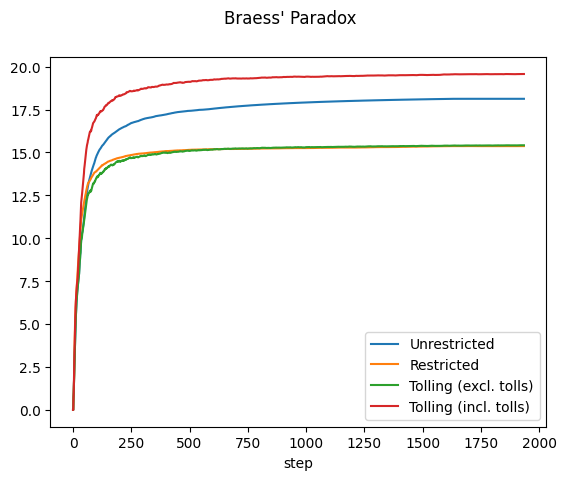

In [17]:
fig, ax = plt.subplots(1, 1)

pd.DataFrame({
    'Unrestricted': car_stats_unrestricted['travel_time'], 
    'Restricted': car_stats_restricted['travel_time'], 
    'Tolling (excl. tolls)': car_stats_tolling['travel_time'], 
    'Tolling (incl. tolls)': car_stats_tolling['total_cost']}).expanding().mean().plot(ax=ax, xlabel='step')

fig.suptitle("Braess' Paradox")

## Use different values for `value_of_money` and check for fairness

In [18]:
def change_value_of_money(cars, possible_values, *, seed=42):
    rng = np.random.default_rng(seed)

    for car in cars.values():
        car.value_of_money = rng.choice(possible_values)

In [20]:
number_of_steps = 1000

network = create_braess_network(capacity=13)
cars = create_cars(network, car_counts={(0, 3): 30})

# Assign different value_of_money to cars
change_value_of_money(cars, [0.0, 0.5, 1.0, 2.0, 5.0])

# Run unrestricted
model = TrafficModel(network, cars)
_, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Unrestricted mean travel time: {(-car_stats_unrestricted["travel_time"]).mean()}')

Unrestricted mean travel time: -18.126296522269676


In [21]:
number_of_steps = 1000

network = create_braess_network(capacity=13)
cars = create_cars(network, car_counts={(0, 3): 30})

# Assign different value_of_money to cars
change_value_of_money(cars, [0.0, 0.5, 1.0, 2.0, 5.0])

# Run restricted
model = TrafficModel(network, cars)
model.set_edge_restriction((1, 2), False)
_, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Restricted mean travel time: {(-car_stats_restricted["travel_time"]).mean()}')

Restricted mean travel time: -15.372417355371901


In [24]:
number_of_steps = 1000

network = create_braess_network(capacity=13)
cars = create_cars(network, car_counts={(0, 3): 30})

# Assign different value_of_money to cars
change_value_of_money(cars, [0.0, 0.5, 1.0, 2.0, 5.0])

# Run tolling
model = TrafficModel(network, cars, tolls=True, beta=1, R=0.5)
_, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Mean travel time with tolling: {(-car_stats_tolling["travel_time"]).mean()}')
print(f'Mean total cost with tolling: {(-car_stats_tolling["total_cost"]).mean()}')

Mean travel time with tolling: -15.58909853249476
Mean total cost with tolling: -21.816268260679188


In [25]:
u = car_stats_unrestricted.groupby('value_of_money')['travel_time'].mean()
r = car_stats_restricted.groupby('value_of_money')['travel_time'].mean()
t = car_stats_tolling.groupby('value_of_money')['travel_time'].mean()

travel_times = pd.concat([u, r, t], keys=['unrestricted', 'restricted', 'tolling'], axis=1)

Text(0.5, 1.0, 'Travel times grouped by value of money')

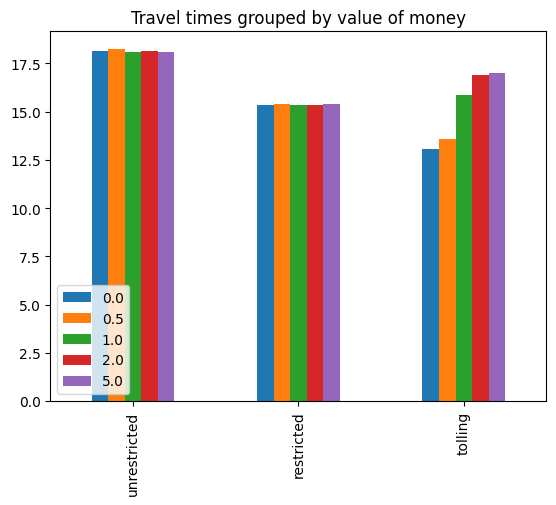

In [27]:
ax = travel_times.transpose().plot(kind='bar')
ax.legend(loc='lower left')
ax.set_title('Travel times grouped by value of money')

In [55]:
from sklearn.linear_model import LinearRegression

LinearRegression().fit(travel_times.index.to_numpy().reshape(-1, 1), travel_times.to_numpy()).coef_

array([[-0.01760653],
       [ 0.00816661],
       [ 0.73239316]])